# Stochastic partial differiential equations - Non conditional simulation

Objective: Perform unconditional simulations of a random field $\bm{Z}$ defined as a solution of the SPDE :

$(\mathcal{\kappa}^{2} - \Delta)^{\alpha}Z = \tau \mathcal{W}$ 

where $\mathcal{\kappa} \gt 0$ and $\mathcal{W}$ is a spatial white noise.



Where $\Gamma$ is the gamma function and $\mathrm{K}_{\nu}$ is the modified Bessel function of the second kind.

$\mathrm{\Kappa} = \dfrac{1}{l}$, with $l$ the length scale parameter

$\tau$ is a normalization constant depending on other parameters as follow

$\tau = \dfrac{\sigma \Gamma(\nu + d/2)^{1/2}(4 \pi)^{d/4} \mathcal{\kappa}^{\nu}}{\Gamma(\nu)^{1/2}}$

- Load the required modules

In [1]:
import logging
from pathlib import Path
import os
from typing import Optional, Union
import numpy as np
import numpy.typing as npt
import scipy
import sksparse
from scipy.spatial import distance_matrix
from scipy.sparse import lil_matrix, csc_matrix
from sklearn.gaussian_process.kernels import Matern as skMatern
import matplotlib.pyplot as plt
import matplotlib as mpl
from nested_grid_plotter import NestedGridPlotter, multi_imshow
import spde
import gstools as gs

- Type hints definition for numpy arrays

In [2]:
NDArrayFloat = npt.NDArray[np.float64]
NDArrayInt = npt.NDArray[np.int64]
Int = Union[int, NDArrayInt]

- Set-up logging level

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [4]:
logging.info(f"numpy version = {np.__version__}")
logging.info(f"scipy version = {scipy.__version__}")
logging.info(f"sksparse version = {sksparse.__version__}")
logging.info(f"matplotlib version = {mpl.__version__}")

INFO:root:numpy version = 1.23.5
INFO:root:scipy version = 1.9.1
INFO:root:sksparse version = 0.4.8
INFO:root:matplotlib version = 3.7.1


- Set a random number generator to obtain reproducible results. Here , we generate a seed from a cool sentence (Note: this is an incremental generator)


In [5]:
rng = np.random.default_rng(np.abs(hash("mike is the best")))

- Create a directory to store the exported figures

In [6]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Make a test on a small grid (10, 10) and plot the matrix (we expect a three bands matrix)

Text(0.5, 1.0, 'Laplacian matrix')

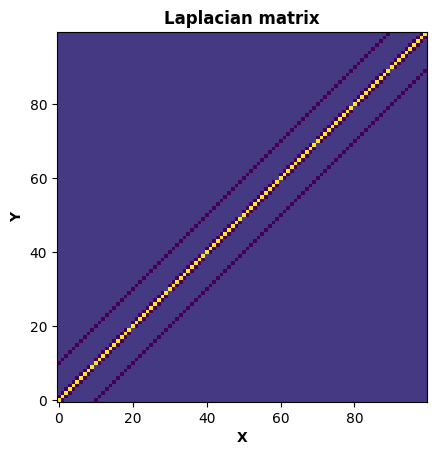

In [7]:
# 1) Test the get laplacian function
kappa = np.ones([10 * 10])
lap_mat = spde.get_laplacian_matrix(10, 10, 1, 1, 1, 1, kappa)

# Plot the sparse matrix -> 3 non null bands
plt.imshow(lap_mat.todense(), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Laplacian matrix", fontweight="bold")

## Unconditional simulation

We obtain an unconditional simulation of the vector $Z$ by solving the linear system introduced above for a vector $\mathcal{W}$ whose components are independent Gaussians of variance $\dfrac{1}{dxdy}$ .

In [26]:
from scipy.sparse.linalg import LinearOperator, gmres


def simu_nc(
    lap_mat: csc_matrix,
    mesh_dims: NDArrayFloat,
    kappa: float,
    alpha: float,
    rng: np.random.Generator,
    preconditioner: Optional[LinearOperator] = None,
    atol=1e-10,
) -> NDArrayFloat:
    """
    Return the gaussian solution of the discretized EDPS (gaussian vector).

    Note
    ----
    This is valid for alpha = 1 only.

    Parameters
    ----------
    lap_mat : csc_matrix
        The laplacian matrix.
    w: NDArrayFloat
        White noise.
    spatial_dim: int
        The number of dimensions (1, 2 or 3).
    rng: np.random.Generator
        Random number generator.
    preconditioner: Optional[LinearOperator]
        Preconditioner for the sparse matrix.
    atol: float
        The tolerance for gmres. The default is 1e-10.

    Returns
    -------
    NDArrayFloat
        The simulation.

    """
    # make sure to have a 1d array of mesh dimensions
    mesh_dims = np.array(mesh_dims).ravel()
    spatial_dim = mesh_dims.size

    # white noise with size nx * ny -> scale is the standard deviation
    w = rng.normal(loc=0, scale=np.sqrt(1 / np.prod(mesh_dims)), size=lap_mat.shape[0])

    # Use a LU preconditioner to get faster computation
    z, info = gmres(lap_mat, w, M=preconditioner, atol=atol)

    nu = 2 * alpha - spatial_dim / 2
    # La variance n'est pas exactement 1. On divise par l'écart type de la variance.
    # tau = kappa * np.sqrt((4 * np.pi * np.math.gamma(2) / np.math.gamma(1)))

    tau = (
        (kappa) ** nu
        * np.sqrt(np.math.gamma(2 * alpha))
        * (4 * np.pi) ** (spatial_dim / 4)
        / np.sqrt(np.math.gamma(nu))
    )

    print(tau)

    return z * tau

## 2D case

- Define some simulation parameters

In [31]:
# We define nx and ny different to check the indexing
nx = 50
ny = 50  # grid size definition (meshes)
nz = 10
n_nodes = nx * ny  # number of meshes
dx = dy = dz = 5.0  # mesh size
kappa = 1 / 30  # inverse of length scale
alpha = 1  # regularity parameter

- Build the laplacian matrix and its LU preconditioner (to solve the Ax  b system faster)

In [32]:
simu_lap_mat_2d = spde.get_laplacian_matrix(nx, ny, 1, dx, dy, 1.0, kappa)
preconditioner_2d = spde.get_preconditioner(simu_lap_mat_2d)

- Non conditional simulation with a given seed for the white noise. Plot the results

0.11816359006036772


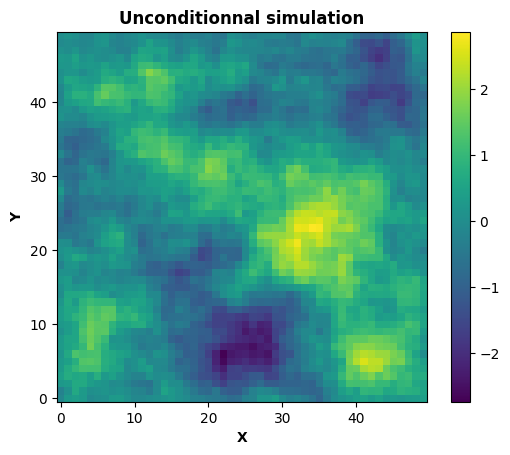

In [60]:
z = simu_nc(
    simu_lap_mat_2d,
    np.array([dx, dy]),
    kappa,
    alpha,
    rng,
    preconditioner=preconditioner_2d,
    atol=1e-25,
)
# Display the simulated field
plt.imshow(z.reshape(nx, ny, order="F").T, origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Unconditionnal simulation", fontweight="bold")
plt.colorbar()

In [61]:
np.std(z)

0.9093990923764408

(array([  1.,   1.,   2.,   9.,  13.,   8.,   6.,   4.,  12.,  15.,  24.,
         24.,  27.,  31.,  45.,  50.,  73.,  70.,  82., 100.,  95., 104.,
        122., 143., 156., 147., 120.,  97., 101., 105.,  90.,  91.,  67.,
         88.,  48.,  64.,  47.,  50.,  39.,  31.,  13.,  15.,  19.,  14.,
         14.,  10.,   5.,   2.,   4.,   2.]),
 array([-2.73029502, -2.61849243, -2.50668984, -2.39488725, -2.28308466,
        -2.17128206, -2.05947947, -1.94767688, -1.83587429, -1.7240717 ,
        -1.61226911, -1.50046652, -1.38866393, -1.27686133, -1.16505874,
        -1.05325615, -0.94145356, -0.82965097, -0.71784838, -0.60604579,
        -0.4942432 , -0.3824406 , -0.27063801, -0.15883542, -0.04703283,
         0.06476976,  0.17657235,  0.28837494,  0.40017753,  0.51198013,
         0.62378272,  0.73558531,  0.8473879 ,  0.95919049,  1.07099308,
         1.18279567,  1.29459826,  1.40640085,  1.51820345,  1.63000604,
         1.74180863,  1.85361122,  1.96541381,  2.0772164 ,  2.18901899,
 

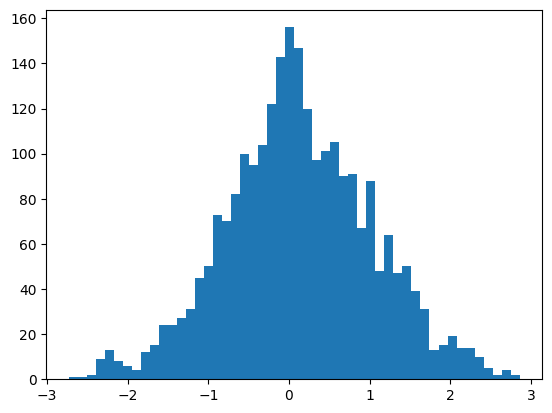

In [62]:
plt.hist(z, bins=50)

### Comparision with a Matérn field

- Define the parameters for the Matérn field

In [88]:
field_dimension = 2  # field dimension

# Variographic parameters: number of points selected in a simulation for the calculation of the experimental variogram
n0 = int(0.2 * (nx * ny))
# Spacestep between points
lag = 4
nbpts = 20  # number of points in the variogram

- Calculation of the average over several simulations of the experimental variogram

In [89]:
nb_sim = 100  # nomber of simulations
varexp = 0

for i in range(nb_sim):
    z0 = simu_nc(
        simu_lap_mat_2d, np.array([dx, dy]), kappa, alpha, rng, preconditioner_2d
    )
    varexp = varexp + spde.get_exp_var(z0, n0, lag, nbpts, nx, ny, dx, dy, rng) / nb_sim

# Add the point (0.0) to varexp -> no nugget effect here
varexp = np.insert(varexp, 0, values=0, axis=0)

In [90]:
varexp

array([[0.00000000e+00, 0.00000000e+00],
       [2.00000000e+00,            nan],
       [6.00000000e+00, 5.26841808e-02],
       [1.00000000e+01, 1.12153073e-01],
       [1.40000000e+01, 1.71149733e-01],
       [1.80000000e+01, 2.11396254e-01],
       [2.20000000e+01, 2.50304414e-01],
       [2.60000000e+01, 3.06938719e-01],
       [3.00000000e+01, 3.60063084e-01],
       [3.40000000e+01, 4.01058396e-01],
       [3.80000000e+01, 4.38434904e-01],
       [4.20000000e+01, 4.73829224e-01],
       [4.60000000e+01, 5.13528428e-01],
       [5.00000000e+01, 5.47084421e-01],
       [5.40000000e+01, 5.72001139e-01],
       [5.80000000e+01, 6.00142028e-01],
       [6.20000000e+01, 6.18490661e-01],
       [6.60000000e+01, 6.37356949e-01],
       [7.00000000e+01, 6.57935076e-01],
       [7.40000000e+01, 6.75960016e-01],
       [7.80000000e+01, 6.77612511e-01]])

- Compute the same with gstools

In [91]:
# positions
X, Y = np.meshgrid(np.arange(nx) * dx, np.arange(ny) * dy)
bin_center, gamma = gs.vario_estimate(
    np.array((X.ravel(), Y.ravel())), field=z0.ravel()
)

In [92]:
bin_center, gamma

(array([  2.40612724,   7.21838172,  12.03063621,  16.84289069,
         21.65514517,  26.46739966,  31.27965414,  36.09190862,
         40.90416311,  45.71641759,  50.52867207,  55.34092656,
         60.15318104,  64.96543552,  69.77769   ,  74.58994449,
         79.40219897,  84.21445345,  89.02670794,  93.83896242,
         98.6512169 , 103.46347139, 108.27572587, 113.08798035]),
 array([0.        , 0.05574429, 0.13548695, 0.21225304, 0.2870188 ,
        0.36181756, 0.4386611 , 0.50797872, 0.57455164, 0.63327201,
        0.68323517, 0.7344294 , 0.77366109, 0.81497844, 0.84437863,
        0.86339272, 0.88228773, 0.89362944, 0.89700359, 0.91000229,
        0.90841197, 0.90632651, 0.91004208, 0.90073045]))

- Plot the experiemental variogram vs. the theoretical one

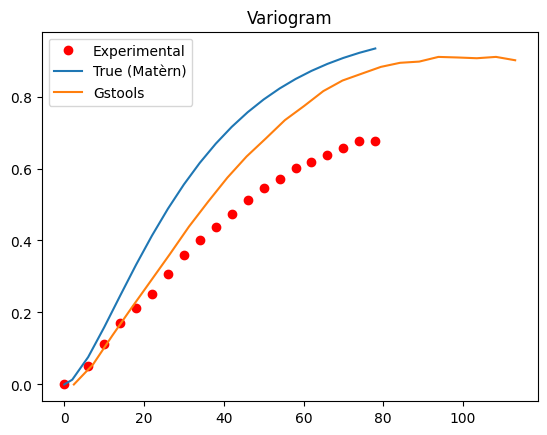

In [93]:
plt.plot(
    varexp[:, 0],
    varexp[:, 1],
    marker="o",
    label="Experimental",
    c="r",
    linestyle="None",
)
# mat_val = matern(varexp[1:, 0], alpha, kappa, spatial_dim)
# mat_val = np.insert(mat_val, 0, values=0, axis=0)

mat_val2 = 1 - spde.matern_kernel(
    varexp[0:, 0], 1 / kappa, 2 * alpha - field_dimension / 2
)

plt.plot(varexp[:, 0], mat_val2, label="True (Matèrn)")
plt.plot(bin_center, gamma, label="Gstools")
plt.title("Variogram")
plt.legend()
plt.show()

## 3D case

In [94]:
simu_lap_mat_3d = spde.get_laplacian_matrix(nx, ny, nz, dx, dy, dz, kappa)

In [95]:
preconditioner_3d = spde.get_preconditioner(simu_lap_mat_3d)

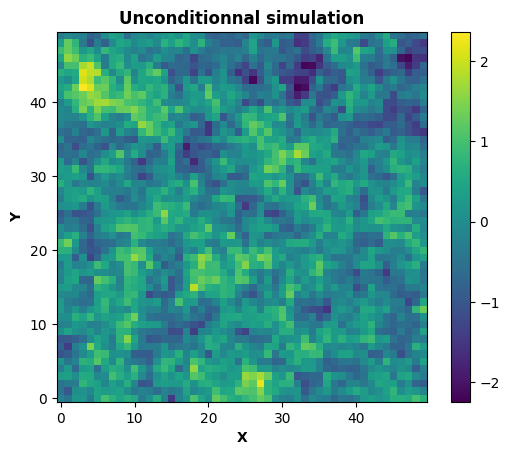

In [96]:
z_3d = simu_nc(
    simu_lap_mat_3d,
    np.array([dx, dy, dz]),
    kappa,
    alpha,
    rng,
    preconditioner=preconditioner_3d,
    atol=1e-20,
)
# Display the simulated field
plt.imshow(z_3d.reshape(nx, ny, nz, order="F")[:, :, 1].T, origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Unconditionnal simulation", fontweight="bold")
plt.colorbar()

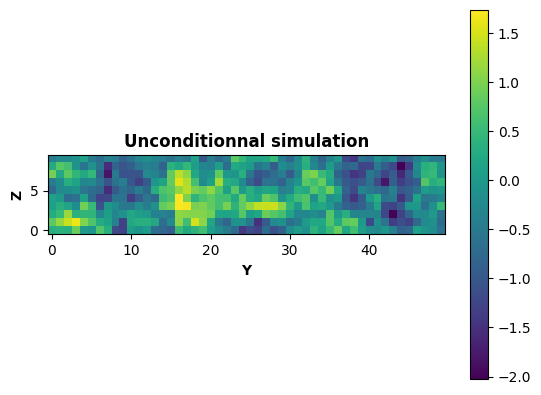

In [97]:
# Display the simulated field
plt.imshow(z_3d.reshape(nx, ny, nz, order="F")[25, :, :].T, origin="lower")
plt.xlabel("Y", fontweight="bold")
plt.ylabel("Z", fontweight="bold")
plt.title("Unconditionnal simulation", fontweight="bold")
plt.colorbar()